# Personal view

The most common feature that help in detection of heart desease are:

- **chest pain type:**

It is not a good **indicator** to show CAD diseases becasue of in the different syptoms, the majority of its values tend to give **no disease**

![chest pain type-count_plot.jpg](attachment:e93895e5-5eb5-4ac4-84da-fd0a88c5f179.jpg)

- **exercise induced angina**

It is a good **indicator** to show CAD diseases becasue the **No** value gives bigger priority for no CAD diseases

![exercise induced angina-count_plot.jpg](attachment:99b9579c-6696-4935-8414-e819fd42d893.jpg)


- **the slop of ST segment**

It is a good **indicator** to show CAD diseases becasue there its values help in distinguishing if there is CAD diseases.

![slope peak exercise ST segment-count_plot.jpg](attachment:966df1dc-b2cb-40b8-a763-0317036a6ad7.jpg)
![download.png](attachment:76589c46-b978-4f07-891a-8c56f7f0e131.png)

- **thallium stress result:** 

the flow of blood to your heart through your coronary arteries, An abnormal test result can reveal coronary blockages as well as damage from heart attacks

It is a good **indicator**

![thallium stress result-count_plot.jpg](attachment:8e68998b-05a6-4dc2-bd1c-f6dca054b5f1.jpg)


- **max heart rate** 
- **age** 
- **ST depression**

In [6]:
PROC_TRAIN_DATA_PATH = "../../data/processed/preprocessed_train_data.pkl"
SELECTED_TRAIN_DATA_PATH = "../../data/preprocessed/selected_train_data.pkl"


# Import packages

In [30]:
from typing import Any, Callable
from functools import wraps

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from dataclasses import dataclass, field
from typing import Union


# Inherit from Base class
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

# Import estimators
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Import imputing features methods 
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer


# Import features selection methods
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, RFE

from sklearn.feature_selection import SequentialFeatureSelector as sk_SFS
from skfeature.function.similarity_based.fisher_score import fisher_score

from mlxtend.feature_selection import SequentialFeatureSelector as mlx_SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


from statsmodels.stats.outliers_influence import variance_inflation_factor 

import warnings
warnings.filterwarnings('ignore')

In [8]:
# Change some pandas display options
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_colwidth", 0)
pd.set_option("display.width", 1000)
pd.set_option("styler.format.precision", 10)


# Read data

In [19]:
df_train = pd.read_pickle(PROC_TRAIN_DATA_PATH)

num_cols = ['age', 'resting blood pressure', 'serum cholestoral', 'maximum heart rate', 'ST depression']
cat_cols = set(df_train.columns.to_list()) - set(num_cols)
cat_cols = list(cat_cols)

# Normality
**Cholesterol** and **ST depression** are not follow the normal distribution<br>
so we will transform them to be normally distributed

In [20]:
rng = np.random.RandomState(304)
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',
                                random_state=rng)
df_train[["serum cholestoral","ST depression"]] = qt.fit_transform(df_train[["serum cholestoral","ST depression"]])
# test_data[["serum cholestoral","ST depression"]] = qt.transform(test_data[["serum cholestoral","ST depression"]])

# Selection

### Filter methods
The current problem contains independent features with categorical target. <br>
Therefore the desired filter methods to be used are **Chi2** and **LDA**:
1. For measuring the independence between Continues features and categorical target, The LDA algorithm should be used because:
    - LDA: Linear discriminant analysis is used to find a linear combination of features that characterizes or separates two or more classes (or levels) of a categorical variable.

2. For measuring the independence between categorical features and categorical target, The chi2 test should be used because:
    - Chi-Square: It is a is a statistical test applied to the groups of categorical features to evaluate the likelihood of correlation or association between them using their frequency distribution.

#### Correlation

<AxesSubplot:>

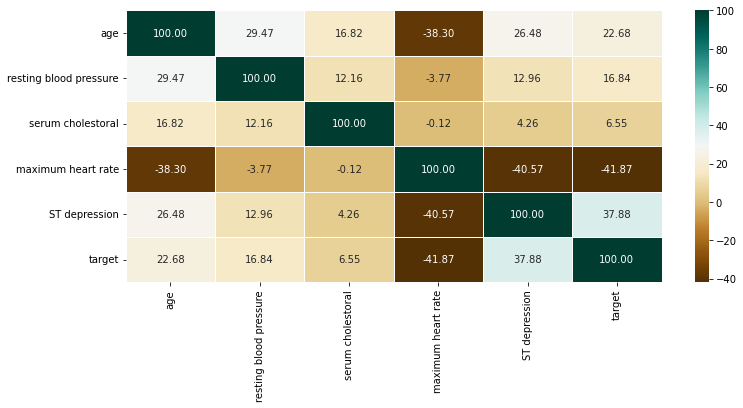

In [21]:
corr_values = df_train[num_cols+['target']].corr()

plt.figure(figsize=(12,5))
sns.heatmap(corr_values*100, linecolor='w', linewidths=1, annot=True, fmt='.2f', cmap = plt.cm.BrBG)

#### Multicollinearity Detecting
Variable Inflation Factors (VIF):
- VIF starts at 1 and has no upper limit
- VIF = 1, no correlation between the independent variable and the other variables
- VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

In conclusion, There is multicollinearity found in:
- **age** and other features
- **maximum heart rate** and other features

In [23]:
vif = pd.DataFrame()
vif_corr_values = df_train[num_cols].corr()
vif["variables"] = vif_corr_values.columns
vif["VIF"] = [variance_inflation_factor(vif_corr_values.values, i) for i in range(vif_corr_values.shape[1])]
vif

,variables,VIF
0,age,2.850474
1,resting blood pressure,1.564995
2,serum cholestoral,1.174653
3,maximum heart rate,2.947551
4,ST depression,2.174020


#### Drawing test scores - bar plot

In [33]:
@dataclass
class TestResult:
    """class for storing test results"""
    specs: list[str]
    scores: list[Union[int, float]]
    res: pd.DataFrame = field(init=False, repr=False)

    def __post_init__(self):
        # Grouping results in DataFrame
        self.res = pd.DataFrame()
        self.res['Specs'] = self.specs
        self.res['Score'] = self.scores

@dataclass
class FeatureRank:
    """class for holding feature ranking"""
    func: Callable[[pd.DataFrame, pd.DataFrame], list[int]]
    X: pd.DataFrame
    y: pd.DataFrame
    test_result: TestResult = field(init=False)

    
    def __post_init__(self):
        
        # Take copy of X and y
        X_np = self.X.to_numpy()
        y_np = self.y.to_numpy()

        # Calculate feature ranking
        ret = self.func(X_np, y_np)

        # Create test result
        ranks = ret[0] if(len(ret)==2) else ret

        print(type(ranks))
        
        # Normalize ranks
        ranks = (ranks - ranks.min()) / (ranks.max() - ranks.min())

        self.test_result = TestResult(self.X.columns, ranks)

        # Change the index of the DataFrame
        self.test_result.res.index = [train_data.columns.get_loc(spec) for spec in self.test_result.res['Specs']]
    
    def get_largest_score(self, n:Union[int, str] = 'auto') -> list[str]:
        """Get the largest n scores"""
        if(isinstance(n, str) and n=='auto'):
            n = self.test_result.res.shape[0]
        
        return self.test_result.res.nlargest(n, columns=['Score'])['Specs'].values.tolist()

    def feat_imp_plot(self, title, sorting=False):
        """Plot feature importance as bar plot"""

        # Take copy of result to avoid modifying on original result
        result = self.test_result.res.copy()
        
        if(sorting):
            result = result.sort_values(by='Score', ascending=False)
            
        fig = plt.figure(figsize=(20,8))
        ax  = fig.add_subplot()
        axs = sns.barplot(x='Specs', y='Score', data=result, palette = 'Reds_r', ax=ax)
        for p in axs.patches:
            axs.annotate('{:.2f}'.format(p.get_height()), (p.get_x(), p.get_height()))
        plt.box(False)
        ax.set_title(title, fontsize=16)
        ax.set_xlabel('\n Features')
        ax.set_ylabel('Importance \n')
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=30)

        return ax

        

#### Chi2 Test
Depending on the p_values and the previous categorical features plots we conclude.<br>
The following features demonstrate significant difference that help in distinguishing CAD diseases:
- exercise induced angina
- slope peak exercise ST segment
- chest pain type
- fasting blood sugar


In [36]:
chi2_rank = FeatureRank(chi2, df_train[cat_cols], df_train['target'])
chi2_rank.feat_imp_plot('Chi2 Test - feature importance', sorting=True)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

#### ANOVA Test
Depending on the p_values and the previous numerical features plots we conclude.<br>
The following features demonstrate significant difference that help in distinguishing CAD diseases:
- max heart rate
- ST depression
- age
- cholesterol


In [ ]:
f_rank = FeatureRank(f_classif, train_data[num_cols], train_data['target'])
f_rank.feat_imp_plot('ANOVA Test - feature importance', sorting=True)

#### Mutual-info method

In [ ]:
mi_rank = FeatureRank(mutual_info_classif, train_data.iloc[:,:-1], train_data['target'])
mi_rank.feat_imp_plot('Mutual-info Test - feature importance', sorting=True)

#### Fisher's Score

In [ ]:
fisher_rank = FeatureRank(fisher_score, train_data.iloc[:,:-1], train_data['target'])
fisher_rank.feat_imp_plot('Fisher Score - feature importance', sorting=True)

#### Comparison

In [ ]:
filter_methods_comp = pd.DataFrame()
filter_methods_comp = pd.concat([filter_methods_comp, mi_rank.test_result.res['Score']], axis=1)
filter_methods_comp = pd.concat([filter_methods_comp, fisher_rank.test_result.res['Score']], axis=1)
# filter_methods_comp = pd.concat([filter_methods_comp, chi2_rank.test_result.res['Score']], axis=1)
# filter_methods_comp = pd.concat([filter_methods_comp, f_rank.test_result.res['Score']], axis=1)
filter_methods_comp.index = index=train_data.columns[:-1]
filter_methods_comp.columns = ['mutual_info', 'fisher']
filter_methods_comp.sort_values(by='mutual_info', ascending=False)


### Wrapper methods

#### RFE

In [ ]:
def rfe_score(X, y):
    """Calculate RFE score"""
    selection_svc_model = DecisionTreeClassifier()
    rfe = RFE(selection_svc_model, n_features_to_select=7, step=1)
    rfe.fit(X, y)

    return rfe.ranking_

rfe_rank = FeatureRank(rfe_score, train_data.iloc[:,:-1], train_data['target'])
rfe_rank.feat_imp_plot('RFE Score - feature importance', sorting=True)



#### SFS

##### built-in library

In [ ]:
def sfs_score(X, y):
    sk_sfs_selector = sk_SFS(
    KNeighborsClassifier(n_neighbors=3), 
    direction='forward',
    scoring='accuracy',
    cv=10, 
    n_jobs=-1
    ).fit(X, y)
    sk_sfs_features = np.array(train_data.columns[:-1])[sk_sfs_selector.get_support()]
    return sk_sfs_features


# sfs_score(train_data.iloc[:,:-1], train_data['target'])
# sfs_rank = FeatureRank(sfs_score, train_data.iloc[:,:-1], train_data['target'])
# sfs_rank.feat_imp_plot('SFS Score - feature importance', sorting=True)


##### Diff library

In [ ]:
def sfs_score(X, y):
    mlx_sfs_selector = mlx_SFS(
        DecisionTreeClassifier(), 
        k_features=X.shape[1],
        forward=True,
        floating=False,
        scoring='accuracy',
        cv=10,
        n_jobs=-1,
    ).fit(X, y)
    # mlx_sfs_features = mlx_sfs_selector.k_feature_names_
    mlx_sfs_scores = mlx_sfs_selector.get_metric_dict()
    return mlx_sfs_scores

# sfs_rank = FeatureRank(sfs_score, train_data.iloc[:,:-1], train_data['target'], train_data.columns[:-1])
# sfs_rank.feat_imp_plot('SFS Score - feature importance', sorting=True)


# fig1 = plot_sfs(mlx_sfs_selector.get_metric_dict(), kind='std_dev')
# plt.title('Sequential Forward Selection (w. StdErr)')
# plt.grid()
# plt.show()

#### Genetic Algorithm

In [ ]:
genetic_model_selector = GeneticSelectionCV(
    SVC(), cv=5, verbose=0,
    scoring="precision",
    n_population=100, crossover_proba=0.5,
    mutation_proba=0.2, n_generations=50,
    crossover_independent_proba=0.5,
    mutation_independent_proba=0.04,
    tournament_size=3, n_gen_no_change=10,
    caching=True, n_jobs=-1)
    
genetic_model_selector = genetic_model_selector.fit(train_data.iloc[:,:-1], train_data['target'])

genetic_features = train_data.iloc[:,:-1].columns[genetic_model_selector.support_]

In [ ]:
genetic_features

### Embedded methods

#### Tree-Based

In [ ]:
def tree_based_score(X, y):
    """Calculate Tree-based score"""
    dt_model_selector = DecisionTreeClassifier()
    dt_model_selector.fit(X, y)
    return dt_model_selector.feature_importances_

tree_based_rank = FeatureRank(tree_based_score, train_data.iloc[:,:-1], train_data['target'])
tree_based_rank.feat_imp_plot('Tree-Based - feature importance', sorting=True)

#### SVM (L1 regularization)

In [ ]:
def svm_score(X, y):
    """Calculate svm score"""
    svm_model_selector = SVC(kernel='linear', decision_function_shape="ovo", random_state=33)
    svm_model_selector.fit(X, y)
    print(svm_model_selector.coef_.shape)
    return svm_model_selector.coef_.ravel()

# svm_rank = FeatureRank(svm_score, train_data.iloc[:,:-1], train_data['target'])
# svm_rank.feat_imp_plot('svm Score - feature importance', sorting=True)



#### Lasso (L1 regularization)

In [ ]:
def lasso_score(X, y):
    """Calculate Lasso score"""
    lasso_model_selector = Lasso(alpha=0.1)
    lasso_model_selector.fit(X, y)
    return lasso_model_selector.coef_

lasso_rank = FeatureRank(lasso_score, train_data.iloc[:,:-1], train_data['target'])
lasso_rank.feat_imp_plot('Lasso - feature importance', sorting=True)

#### Comparison

In [ ]:
embedded_methods_comp = pd.DataFrame()
embedded_methods_comp = pd.concat([embedded_methods_comp, tree_based_rank.test_result.res['Score']], axis=1)
# embedded_methods_comp = pd.concat([embedded_methods_comp, svm_rank.test_result.res['Score']], axis=1)
# embedded_methods_comp = pd.concat([embedded_methods_comp, lasso_rank.test_result.res['Score']], axis=1)
embedded_methods_comp.index = index=train_data.columns[:-1]
embedded_methods_comp.columns = ['tree_based']
embedded_methods_comp.sort_values(by='tree_based', ascending=False)


## Important Features
In comparison between graphs and statistical test, the conclusion about the most contribution features are:
   - for categorical features:
      1. **slope peak exercise ST segment** 
      2. **exercise induced angina** 
      3. **chest pain type**
      4. **sex**
   - for numerical features:
      1. **max heart rate** 
      2. **age** 
      3. **ST depression**

In [ ]:
filter_embedded_comp = pd.concat([embedded_methods_comp, filter_methods_comp], axis=1)

# Save DataFrame in excel file
filter_embedded_comp.to_excel('filter_embedded_comp.xlsx')
filter_embedded_comp['Avg'] = filter_embedded_comp.sum(axis=1)

# Normalize Avg column
filter_embedded_comp['Avg'] = (filter_embedded_comp['Avg'] - filter_embedded_comp['Avg'].min()) / (filter_embedded_comp['Avg'].max() - filter_embedded_comp['Avg'].min()) 
filter_embedded_comp = filter_embedded_comp.sort_values('Avg', ascending=False)

In [ ]:
filter_embedded_comp

In [ ]:
# Compare between filter method and embedded method performance
filter_embedded_comp.sort_values(by='mutual_info', ascending=False).plot(kind='bar', figsize=(10,5))
plt.title('Filter Method vs Embedded Method')
plt.grid()



In [ ]:

ax = filter_embedded_comp['Avg'].plot.bar(width=0.8, figsize=(20,10), colormap='Paired')

ax.bar_label(ax.containers[0])

plt.title('Filter Embedded Comparison - Avg')
plt.grid()

## Selected Features

In [ ]:

# gg = mi_rank.get_largest_score(n=9) + ['target']
gg = filter_embedded_comp.nlargest(9, 'Avg').index.to_list() + ['target']
selected_train_data = train_data[gg] 
selected_test_data = test_data[gg] 

# selected_train_data = train_data[genetic_features.tolist() + ['target']] 
# selected_test_data = test_data[genetic_features.tolist() + ['target']] 

# Scaling
Normalizing features helps to increase model's accuracy

In [130]:
scaled_train_data = selected_train_data.copy()
scaled_test_data = selected_test_data.copy()

norm_scaler = MinMaxScaler()
scaled_train_data[selected_train_data.columns[:-1]] = norm_scaler.fit_transform(scaled_train_data[selected_train_data.columns[:-1]])
scaled_test_data[selected_train_data.columns[:-1]] = norm_scaler.transform(scaled_test_data[selected_train_data.columns[:-1]])
